In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, f1_score
import numpy as np
import re
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel


2023-11-30 16:22:24.543796: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 16:22:24.546168: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 16:22:24.598358: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 16:22:24.600067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 16:22:25.582557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


# Simple text preprocessing function
def preprocess_text(s):
    # Lowercase text
    s = s.lower()
    # Replace URLs with a space in the message
    s = re.sub(r'http\S+', ' ', s)
    # Replace ticker symbols with a space
    s = re.sub(r'\$\w*', ' ', s)
    # Replace everything not a letter or apostrophe with a space
    s = re.sub(r'[^a-z\']', ' ', s)
    # Remove single letter words
    s = re.sub(r'\s+[a-z]\s+', ' ', s)
    # Remove multiple spaces with a single space
    s = re.sub(r'\s+', ' ', s)
    return s.strip()


# Select a subset of the dataset
train_data_selected = train_data[:8500]
test_data_selected = test_data[:3600]

# Split into training and validation sets
train_texts, val_texts, train_targets, val_targets = train_test_split(train_data_selected['text'], train_data_selected['target'], test_size=0.1)

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)



# Apply preprocessing to text data
train_texts = train_texts.apply(preprocess_text)
val_texts = val_texts.apply(preprocess_text)
test_texts = test_data['text'].apply(preprocess_text)


# BERT encoding
max_len = 128
train_input = bert_encode(train_texts, bert_tokenizer, max_len=max_len)
val_input = bert_encode(val_texts, bert_tokenizer, max_len=max_len)
test_input = bert_encode(test_texts, bert_tokenizer, max_len=max_len)


#BERT model

input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

bert_output = bert_model(input_word_ids, attention_mask=input_mask, token_type_ids=segment_ids)[1]
dropout_layer = Dropout(0.3)(bert_output)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])


model.fit(train_input, train_targets, batch_size=16, epochs=3, validation_data=(val_input, val_targets))


2023-11-30 16:22:56.401174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertM

Epoch 1/3
429/429 [==============================] - 3030s 7s/step - loss: 0.4685 - accuracy: 0.7930 - val_loss: 0.3510 - val_accuracy: 0.8596
Epoch 2/3
429/429 [==============================] - 3006s 7s/step - loss: 0.3300 - accuracy: 0.8686 - val_loss: 0.4743 - val_accuracy: 0.8176
Epoch 3/3
429/429 [==============================] - 3006s 7s/step - loss: 0.2126 - accuracy: 0.9215 - val_loss: 0.4272 - val_accuracy: 0.8425


In [3]:
# Prediction Function
def predict(model, test_input):
    predictions = model.predict(test_input)
    return [1 if p > 0.5 else 0 for p in predictions.flatten()]

# Make predictions
val_predictions = predict(model, val_input)
test_preds = predict(model, test_input)


precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_predictions, average='weighted')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')

submission = pd.DataFrame({'id': test_data['id'], 'target': test_preds})

# Save the submission file
submission.to_csv('submission_BERT.csv', index=False)

print("Submission file saved as 'submission_BERT.csv'")


102/102 [==============================] - 378s 4s/step
Validation Precision: 0.8425
Validation Recall: 0.8425
Validation F1 Score: 0.8414
Submission file saved as 'submission_BERT.csv'


24/24 [==============================] - 88s 4s/step


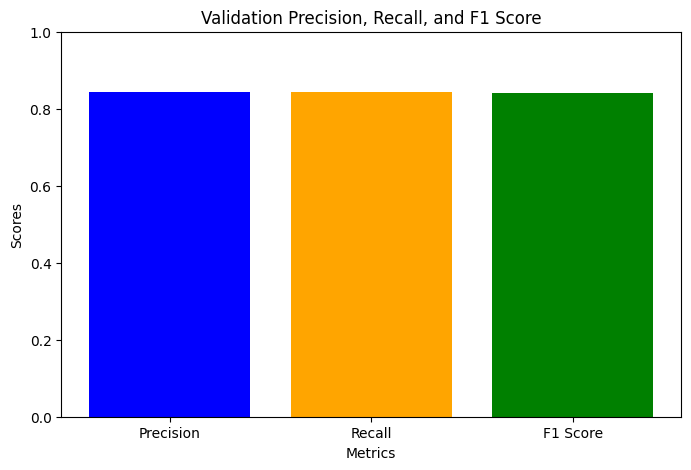

24/24 [==============================] - 88s 4s/step


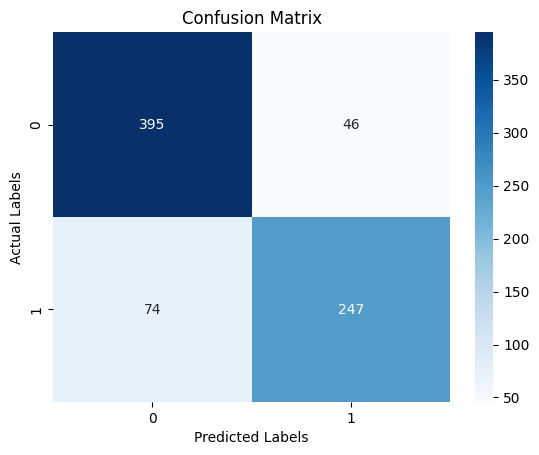

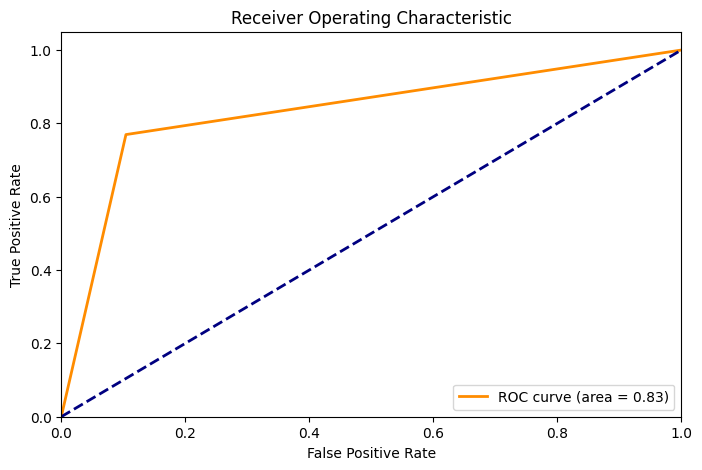

In [4]:
# Function to evaluate the model (precision, recall, F1)
def evaluate(model, val_input, val_targets):
    val_predictions = model.predict(val_input)
    val_predictions = [1 if p > 0.5 else 0 for p in val_predictions]

    precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_predictions, average='weighted')
    return precision, recall, f1

# Calculate precision, recall, and F1 score
precision, recall, f1 = evaluate(model, val_input, val_targets)

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(8, 5))
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']
plt.bar(metric_names, metrics, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Validation Precision, Recall, and F1 Score')
plt.ylim(0, 1)  
plt.show()

# Confusion Matrix
val_predictions = model.predict(val_input)
val_predictions = [1 if p > 0.5 else 0 for p in val_predictions]

cm = confusion_matrix(val_targets, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(val_targets, val_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [2]:
# Values from the confusion matrix
TP = 247
TN = 395
FP = 46
FN = 74

# Total number of samples
total = TP + TN + FP + FN

# Calculate accuracy
accuracy = (TP + TN) / total

# Print
print(f'Accuracy = (TP + TN) / (TP + TN + FP + FN) = ({TP} + {TN}) / ({TP} + {TN} + {FP} + {FN})')
print(f'Calculated Accuracy: {accuracy:.4f}')


Accuracy = (TP + TN) / (TP + TN + FP + FN) = (247 + 395) / (247 + 395 + 46 + 74)
Calculated Accuracy: 0.8425
